# Bucket plot visualisations for motor insurance claim frequency models
Using an open source data set of French Motor Claims as an example to demonstrate how `bucketplot` visualisations can be used in the modelling process.

This notebook is available in the following locations. These versions are kept in sync *manually* - there should not be discrepancies, but it is possible.
- On Kaggle: <https://www.kaggle.com/btw78jt/bucketplot-motor-claims>
- In the GitHub project repo: <https://github.com/A-Breeze/bucketplot>. See the project `README.md` for important information and further instructions.

<!-- This table of contents is updated *manually* -->
# Contents
1. [Setup](#Setup)
1. [Modelling data](#Modelling-data): Load data, Subset, Pre-processing
1. [Build models](#Build-models): Split for modelling, Mean model, Vehicle-only model, Simple features model, Score
1. [Bucket plot visualisation](#Bucket-plot-visualisation): Motivation, Steps, Data types, Examples to use
1. [Assigning buckets](#Assigning-buckets): [divide_n](#divide_n), [custom_width](#custom_width), [weighted_quantiles](#weighted_quantiles), [all_levels](#all_levels)
1. [Group and aggregate](#Group-and-aggregate): NOT COMPLETE
1. [Plot](#Plot): NOT COMPLETE
1. [Worked examples](#Worked-example): NOT COMPLETE
1. [Rough work](#Rough-work)

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Setup

In [1]:
# Set warning messages
import warnings
# Show all warnings in IPython
warnings.filterwarnings('always')
# Ignore specific numpy warnings (as per <https://github.com/numpy/numpy/issues/11788#issuecomment-422846396>)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# Other warnings that sometimes come up
warnings.filterwarnings("ignore", message="unclosed file <_io.TextIOWrapper")
warnings.filterwarnings("ignore", message="unclosed file <_io.Buffered")
warnings.filterwarnings("ignore", message="Anscombe residuals currently unscaled")

In [2]:
# Determine whether this notebook is running on Kaggle
from pathlib import Path

on_kaggle = False
print("Current working directory: " + str(Path('.').absolute()))
if str(Path('.').absolute()) == '/kaggle/working':
    on_kaggle = True

Current working directory: P:\Users\Alex_Breeze\bucketplot\development\compiled


In [3]:
# Import built-in modules
import sys
import platform
import os
from pathlib import Path
import functools
import inspect

# Import external modules
from IPython import __version__ as IPy_version
import numpy as np
import pandas as pd
import bokeh
import bokeh.palettes
import bokeh.io
import bokeh.plotting
from sklearn import __version__ as skl_version
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels import __version__ as sm_version
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Import project modules
if not on_kaggle:
    # Allow modules to be imported relative to the project root directory
    from pyprojroot import here
    root_dir_path = here()
    if not sys.path[0] == root_dir_path:
        sys.path.insert(0, str(root_dir_path))
import bucketplot as bplt

# For development, allow the project modules to be reloaded every time they are used
%load_ext autoreload
%aimport bucketplot
%autoreload 1

# Check they have loaded and the versions are as expected
assert platform.python_version_tuple() == ('3', '6', '6')
print(f"Python version:\t\t{sys.version}")
assert IPy_version == '7.13.0'
print(f'IPython version:\t{IPy_version}')
assert np.__version__ == '1.18.2'
print(f'numpy version:\t\t{np.__version__}')
assert pd.__version__ == '0.25.3'
print(f'pandas version:\t\t{pd.__version__}')
assert bokeh.__version__ == '2.0.1'
print(f'bokeh version:\t\t{bokeh.__version__}')
assert skl_version == '0.22.2.post1'
print(f'sklearn version:\t{skl_version}')
assert mpl.__version__ == '3.2.1'
print(f'matplotlib version:\t{mpl.__version__}')
assert sm_version == '0.11.0'
print(f'statsmodels version:\t{sm_version}')
print(f'bucketplot version:\t{bplt.__version__}')

Python version:		3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
IPython version:	7.13.0
numpy version:		1.18.2
pandas version:		0.25.3
bokeh version:		2.0.1
sklearn version:	0.22.2.post1
matplotlib version:	3.2.1
statsmodels version:	0.11.0
bucketplot version:	0.1.0


In [4]:
# Set the matplotlib defaults
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 8, 6

# Load Bokeh for use in a notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [5]:
if on_kaggle:
    # Output exact environment specification, in case it is needed later
    print("Capturing full package environment spec")
    print("(But note that not all these packages are required)")
    !pip freeze > requirements_snapshot.txt
    !jupyter --version > jupyter_versions_snapshot.txt

In [6]:
# Configuration variables
if on_kaggle:
    claims_data_filepath = Path('/kaggle/input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv')
else:
    import proj_config
    claims_data_filepath = proj_config.EXAMPLE_DATA_DIR_PATH / 'freMTPL2freq.csv'
if claims_data_filepath.is_file():
    print("Correct: CSV file is available for loading")
else:
    print(
        "Warning: CSV file not yet available in that location\n"
        "Please download it manually from here:\n"
        "https://www.openml.org/d/41214"
    )

Correct: CSV file is available for loading


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Modelling data

## Load data

In [7]:
expected_dtypes = {
    **{col: np.dtype('int64') for col in [
        'IDpol', 'ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']},
    **{col: np.dtype('float64') for col in ['Exposure']},
    **{col: np.dtype('O') for col in ['Area', 'VehBrand', 'VehGas', 'Region']},
}

In [8]:
%%time
# The first download can take approx 1 min on Binder
if not claims_data_filepath.is_file():
    from sklearn.datasets import fetch_openml
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", category=UserWarning,
            message='Version 1 of dataset freMTPL2freq is inactive'
        )
        print("Fetching data...")
        df_raw = fetch_openml(data_id=41214, as_frame=True, cache=False).frame.apply(
            lambda col_sers: col_sers.astype(expected_dtypes[col_sers.name])
        ).sort_values('IDpol').reset_index(drop=True)
    # Cache data within the repo, so we don't have to download it many times
    print("Saving data...")
    df_raw.to_csv(claims_data_filepath, index=False)
    print("Save complete")
else:
    print("Loading data from CSV...")
    df_raw = pd.read_csv(
        claims_data_filepath, delimiter=',', dtype=expected_dtypes,
        # Get index sorted with ascending IDpol, just in case it is out or order
    ).sort_values('IDpol').reset_index(drop=True)
    print("Load complete")

Loading data from CSV...


Load complete
Wall time: 1.62 s


In [9]:
# Reasonableness checks that it has loaded as expected
nRows, nCols = (678013, 12)
assert df_raw.shape == (nRows, nCols)
print(f"Correct: Shape of DataFrame is as expected: {nRows} rows, {nCols} cols")
assert df_raw.dtypes.equals(pd.Series(expected_dtypes)[df_raw.columns])
print("Correct: Data types are as expected")
assert df_raw.isna().sum().sum() == 0
print("Correct: There are no missing values in the dataset")

Correct: Shape of DataFrame is as expected: 678013 rows, 12 cols
Correct: Data types are as expected
Correct: There are no missing values in the dataset


## Subset
This notebook is about visualisation, rather than model building, so we can choose a smaller sample of the data to allow the code to run quickly. If you are working on a larger system, consider increasing the sample size to the whole data set.

In [10]:
# Hard-coded stats for reasonableness checks
mean_approx = pd.Series({
    'ClaimNb': 0.0532,
    'Exposure': 0.5288,
    'VehPower': 6.45,
    'VehAge': 7.04,
    'DrivAge': 45.50,
    'BonusMalus': 59.8,
    'Density': 1792.,
})

In [11]:
nrows_sample = int(1e4)
if not on_kaggle or on_kaggle:  # <<<<<<<<<<<<<<<<<<< TODO: redo this
    df_raw, df_unused = train_test_split(
        df_raw, train_size=nrows_sample, random_state=35, shuffle=True
    )

In [12]:
# Check it is as expected, within reason
tol_pc = 0.05
df_sample_means = df_raw[mean_approx.index].mean()
assert df_sample_means.between(
    mean_approx * (1 - tol_pc),
    mean_approx * (1 + tol_pc)
).all()
print("Correct: Reasonableness checks have passed")

Correct: Reasonableness checks have passed


## Pre-processing

In [13]:
def get_df_extra(df_raw):
    """
    Given a DataFrame of that contains the raw data columns (and possibly additional columns), 
    return the DataFrame with additional pre-processed columns
    """
    df_extra = df_raw.copy()
    
    # Calculate frequency per year on each row
    df_extra['Frequency'] = df_extra['ClaimNb'] / df_extra['Exposure']
    
    return(df_extra)

In [14]:
# Run pre-processing to get a new DataFrame
df = get_df_extra(df_raw)

In [15]:
expl_var_names = [
    col_name for col_name in df.columns.to_list() 
     if col_name not in ['IDpol', 'ClaimNb', 'Exposure', 'Frequency']
]
print("Explanatory variables\n" + '\t'.join(expl_var_names))
simple_features = expl_var_names[:9]
print("\nOf which the following are simple features\n" + '\t'.join(simple_features))

Explanatory variables
Area	VehPower	VehAge	DrivAge	BonusMalus	VehBrand	VehGas	Density	Region

Of which the following are simple features
Area	VehPower	VehAge	DrivAge	BonusMalus	VehBrand	VehGas	Density	Region


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Build models
## Split modelling data

In [16]:
# Split training into train and test
df_train, df_test = train_test_split(
    df, test_size=0.3, random_state=34, shuffle=True
)
print("Train sample size: " + str(df_train.shape))

Train sample size: (7000, 13)


In [17]:
# Add indicator column
df = df.assign(
    split=lambda df: np.select(
        [df.index.isin(df_train.index)],
        ['Train'],
        default='Test'
    )
)
df['split'].value_counts()

Train    7000
Test     3000
Name: split, dtype: int64

## Mean model

In [18]:
%%time
GLMres_mean = smf.glm(
    "ClaimNb ~ 1",
    data=df_train, exposure=np.asarray(df_train['Exposure']),
    family=sm.families.Poisson(sm.genmod.families.links.log()),
).fit()
print(GLMres_mean.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1456.8
Date:                Sun, 31 May 2020   Deviance:                       2210.1
Time:                        18:28:21   Pearson chi2:                 1.72e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3282      0.053    -44.174      0.0

In [19]:
# Check that this is the mean model
mean_mod_pred = np.exp(GLMres_mean.params[0])
assert np.abs(
    GLMres_mean.family.link.inverse(GLMres_mean.params[0]) - 
    GLMres_mean.predict(pd.DataFrame([1]))[0]
) < 1e-10
assert np.abs(
    df_train.ClaimNb.sum() / df_train.Exposure.sum() - 
    mean_mod_pred
) < 1e-10
print("Correct: Reasonableness tests have passed")

Correct: Reasonableness tests have passed


## Vehicle-only model

In [20]:
veh_features =['VehPower', 'VehAge', 'VehBrand', 'VehGas']

In [21]:
%%time
# Takes a few secs
GLMres_veh = smf.glm(
    "ClaimNb ~ " +  ' + '.join(veh_features),
    data=df_train, exposure=np.asarray(df_train['Exposure']),
    family=sm.families.Poisson(sm.genmod.families.links.log()),
).fit()
print(GLMres_veh.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6986
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1445.5
Date:                Sun, 31 May 2020   Deviance:                       2187.6
Time:                        18:28:21   Pearson chi2:                 1.61e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.8965    

## Simple factors model

In [22]:
%%time
# Takes approx 10 secs
GLMres_simple = smf.glm(
    "ClaimNb ~ " +  ' + '.join(simple_features),
    data=df_train, exposure=np.asarray(df_train['Exposure']),
    family=sm.families.Poisson(sm.genmod.families.links.log()),
).fit()
print(GLMres_simple.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6957
Model Family:                 Poisson   Df Model:                           42
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1417.7
Date:                Sun, 31 May 2020   Deviance:                       2132.1
Time:                        18:28:21   Pearson chi2:                 1.67e+04
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.8697    

## Score data
All data (training and test rows) on both models

In [23]:
%%time
# Score all data (training and test)
df = df.assign(
    Freq_pred_mean=lambda df: GLMres_mean.predict(df),
    Freq_pred_veh=lambda df: GLMres_veh.predict(df),
    Freq_pred_simple=lambda df: GLMres_simple.predict(df),
)

Wall time: 172 ms


In [24]:
# Check reasonableness
# The actual sum of ClaimNB should exactly match each model's predicted sum on the training data
pred_claims_df = df.assign(
    ClaimNb_pred_mean=lambda df: df['Freq_pred_mean'] * df['Exposure'],
    ClaimNb_pred_veh=lambda df: df['Freq_pred_veh'] * df['Exposure'],
    ClaimNb_pred_simple=lambda df: df['Freq_pred_simple'] * df['Exposure'],
).groupby('split').agg(
    n_obs=('split', 'size'),
    Exposure=('Exposure', 'sum'),
    ClaimNb=('ClaimNb', 'sum'),
    ClaimNb_pred_mean=('ClaimNb_pred_mean', 'sum'),
    ClaimNb_pred_veh=('ClaimNb_pred_veh', 'sum'),
    ClaimNb_pred_simple=('ClaimNb_pred_simple', 'sum'),
)
assert np.max(np.abs(
    pred_claims_df.loc['Train'].iloc[-3:] - pred_claims_df.loc['Train', 'ClaimNb']
)) < 1e-8
pred_claims_df

,n_obs,Exposure,ClaimNb,ClaimNb_pred_mean,ClaimNb_pred_veh,ClaimNb_pred_simple
split,,,,,,
Test,3000,1573.751502,156,153.397556,151.750382,150.327057
Train,7000,3693.347905,360,360.000000,360.000000,360.000000


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Bucket plot visualisation
## Motivation
Suppose we want to view the one-way of how the response `Frequency` varies according to some other variable. Let's try a scatter plot for `DrivAge`.

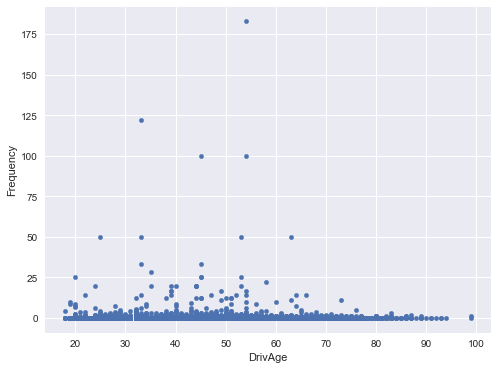

In [25]:
x_var, stat_var = 'DrivAge', 'Frequency'
df.plot.scatter(x_var, stat_var)
plt.show()

This isn't very helpful because:
- With a large amount of data, a scatter plot doesn't give a good indication of where it is most concentrated. Points overlap.
- For imbalanced count (or frequency) data, a large proportion of the data rows have a response of zero.
- The plot must cover the whole range, including any outliers on either axis.

What we want to do is partition the x-axis variable into *buckets*, and plot the *average* respose in each bucket. At the same time, we also want to plot along with the *distribution* of the x-axis variable, to give a sense of the relative credbility of the estimate from each bucket. As follows, this is a task for `pd.cut()` + `groupby` + `agg`. 

## Steps
1. Assign rows to buckets. 
    - *Every* row is assigned to one bucket. There may be buckets that contain no rows (use `n_obs` aggregate variable to determine this).
    - The buckets are `Categorical` with each bucket being an `Interval`. There are no gaps between the intervals. The bucket can be missing (i.e. `NaN`), in which case the row will be excluded on grouping the data.
1. Group the data by bucket. Within each bucket consider the distribution of columns values *weighted* by `stat_wgt`. Calculate aggregate figures for each bucket:
    - *x* coordinate edges: (`x_left`, `x_right`). Must not overlap (but there can be gaps). Must be `x_left` < `x_right` *or* both `NaN`.
    - Sum of `stat_wgt` to be plotted as a histogram
    - One point coordinate per statistic to be plotted at (`x_point`, `stat_val`)
1. Plot 

## Data types
Data types of individual columns for bucket plots:
- Numeric (`int` or `float`)
    - Continuous = a high number (or high proportion) of unique values
        - Pure
        - With concentration at one value
    - Discrete / ordinal = a low number of unique values. Ordered. May have categories with no occurrences in the data.
- Non-numeric (`str`)
    - Ordinal = as above.
    - Nominal = finite number of categories, not ordered.
- Others: not appropriate to plot

Other specifications:
- Weights:
    - All non-negative with at least one positive.
    - Might contain repeated values.

## Examples to use

In [26]:
# Look at first few rows
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency,split,Freq_pred_mean,Freq_pred_veh,Freq_pred_simple
262130,2123898,0,0.18,'C',5,0,77,50,'B1','Diesel',229,'R53',0.0,Train,0.097473,0.129705,0.225313
101817,1023337,0,0.49,'A',5,14,87,58,'B2','Regular',16,'R24',0.0,Train,0.097473,0.078510,0.113688
309928,2221739,0,0.82,'E',9,12,55,50,'B2','Regular',3317,'R93',0.0,Train,0.097473,0.074974,0.079398
426405,3141367,0,1.00,'C',5,3,48,50,'B12','Regular',102,'R82',0.0,Train,0.097473,0.138212,0.127007
162742,1142829,0,0.73,'B',7,3,32,61,'B10','Regular',57,'R24',0.0,Train,0.097473,0.142744,0.095605


In [27]:
# Weights
# df['Exposure'] - none are zero
# df['ClaimNb'] - many are zero

# Numeric
# df['Density'] - close to continuous with a large skew
# df['DrivAge'] - between discrete (ordinal) and continuous
# df['Exposure'] - close to continuous, odd distribution
# df['Frequency'] - continuous with a concentration at 0
# df['Freq_pred_veh'] and df['Freq_pred_simple'] - continuous and positive

# Non-numeric
# df['Area'] - nominal with a low number of levels
# df['Region'] and df['VehBrand'] - nominal with a higher number of levels

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Assigning buckets
Every method:
- Takes a DataFrame `df` and the name `bucket_var` of a column.
- Uses other arguments to append a column `bucket` of which bucket each row is assigned to. The column data type will be `Categorical` where the categories are:
    - `Interval`s for numeric bucket methods.
    - Single values for non-numeric bucket methods.
- Returns the enlarged `df`.

Possible methods:
- Numeric:
    - `divide_n`: Split range into `n_bins` equal width buckets. Any numeric data. For discrete data, want `n_bins` to be much smaller than the number of unique values.
    - `custom_width`: Specify the `width` and `boundary` point. Options for `first_break` and `last_break` for larger width buckets at either end. Any numeric data.
    - `weighted_quantile`: Quantiles of `bucket_var` weighted by `bucket_wgt` (which can be special value `const`). Aim for `n_bins` but note that there are only a finite number of cut points (especially when `bucket_var` is discrete or is concentrated at only a few points).
- Non-numeric:
    - `all_levels`: One bucket for each level.

Other methods would also be possible.

### Technicalities
- An interval index can only contain half-open intervals that are all closed on the same side, i.e. all $(a,b]$ or $[a,b)$. We will *always* stick to the default of closed on the *right*. To ensure all rows fall within a bucket, `pd.cut()` extends the bottom bucket by 0.1% of the entire range (when passing an `int` to `bins`). In any custom implementations, we replicate this convention.

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

## divide_n

In [28]:
def divide_n(df, bucket_var, n_bins=10, bucket_col='bucket'):
    """
    Assign each row of `df` to a bucket by dividing the range of the 
    `bucket_var` column into `n_bins` number of equal width intervals.
    
    df: DataFrame
    bucket_var: Name of the column of df to use for dividing
    n_bins: positive integer number of buckets
    bucket_col: Name of the resulting `bucket` column
    
    Returns: df with the additional `bucket` column 
        The `bucket` column is Categorical data type consisting of Intervals
        that partition the interval from just below min(bucket_var) to 
        max(bucket_var).
    """
    df_w_buckets = df.assign(**{bucket_col: (
        lambda df: pd.cut(df[bucket_var], bins=n_bins)
    )})
    return(df_w_buckets)

In [29]:
bucket_var = 'Density'
# bucket_var = 'Exposure'
# bucket_var = 'DrivAge'
tmp1 = df.pipe(divide_n, bucket_var, 10)
tmp1.groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('Exposure', 'sum'),
    stat_sum=('ClaimNb', 'sum'),
    x_min=(bucket_var, 'min'),
    x_max=(bucket_var, 'max'),
)

,n_obs,stat_wgt_sum,stat_sum,x_min,x_max
bucket,,,,,
"(-24.998, 2701.8]",7964,4312.504443,405,2.0,2699.0
"(2701.8, 5401.6]",1322,629.770314,76,2710.0,5376.0
"(5401.6, 8101.4]",199,86.490000,4,5410.0,8023.0
"(8101.4, 10801.2]",259,114.011910,12,8346.0,10477.0
"(10801.2, 13501.0]",13,6.250000,1,10961.0,12750.0
"(13501.0, 16200.8]",33,17.070000,4,13520.0,16052.0
"(16200.8, 18900.6]",38,18.212740,2,16284.0,18229.0
"(18900.6, 21600.4]",0,0.000000,0,NaN,NaN
"(21600.4, 24300.2]",12,5.390000,0,22669.0,22821.0


In [30]:
# Edge cases
# Resulting bucket with no obs
pd.Series([0, 1]).to_frame('val').pipe(
    divide_n, 'val', 3
).groupby('bucket').agg(n_rows=('bucket', 'size'))

# Constant bucket_var
pd.Series([0, 0]).to_frame('val').pipe(
    divide_n, 'val', 2
).groupby('bucket').agg(n_rows=('bucket', 'size'))

# n_bins = 1
pd.Series([0, 1]).to_frame('val').pipe(
    divide_n, 'val', 1
).groupby('bucket').agg(n_rows=('bucket', 'size'))

,n_rows
bucket,
"(-0.001, 1.0]",2


In [31]:
# Missing vals
unit_w_miss = pd.Series([0, 1, np.nan]).to_frame('val').pipe(
    divide_n, 'val', 3
)
display(unit_w_miss)  # Given a bucket 'NaN'...
display(  # ...which is not included after grouping
    unit_w_miss.groupby('bucket').agg(n_rows=('bucket', 'size'))  
)

,val,bucket
0,0.0,"(-0.001, 0.333]"
1,1.0,"(0.667, 1.0]"
2,NaN,NaN


,n_rows
bucket,
"(-0.001, 0.333]",1
"(0.333, 0.667]",0
"(0.667, 1.0]",1


In [32]:
# Use a missing indicator to cope with missing values
unit_filled = pd.Series([0, 1, np.nan]).to_frame('val').assign(
    val_miss_ind=lambda df: df.val.isna() + 0,
    val=lambda df: df.val.fillna(0),
).pipe(
    divide_n, 'val', 3).pipe(
    # Would be more natural to use all_levels() in this case
    divide_n, 'val_miss_ind', 2, 'bucket_miss_ind'  
)
display(unit_filled)
unit_filled.groupby(['bucket_miss_ind', 'bucket']).agg(
    n_rows=('bucket', 'size')
)

,val,val_miss_ind,bucket,bucket_miss_ind
0,0.0,0,"(-0.001, 0.333]","(-0.001, 0.5]"
1,1.0,0,"(0.667, 1.0]","(-0.001, 0.5]"
2,0.0,1,"(-0.001, 0.333]","(0.5, 1.0]"


n_rows
bucket_miss_ind bucket                 
(-0.001, 0.5]   (-0.001, 0.333]       1
                (0.667, 1.0]          1
(0.5, 1.0]      (-0.001, 0.333]       1

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

## custom_width

In [33]:
def custom_width(
    df, bucket_var,
    width, boundary=0,
    first_break=None, last_break=None,
    bucket_col='bucket'
):
    """
    Assign each row of `df` to a bucket by dividing the range of the 
    `bucket_var` column into `n_bins` number of equal width intervals.
    
    df: DataFrame
    bucket_var: Name of the column of df to use for dividing.
    width: Positive width of the buckets
    boundary: Edge of one of the buckets, if the data extended that far
    first_break: All values below this (if any) are grouped into one bucket
    last_break: All values above this (if any) are grouped into one bucket
    bucket_col: Name of the resulting `bucket` column
    
    Returns: df with the additional `bucket` column 
        The `bucket` column is Categorical data type consisting of Intervals
        that partition the interval from just below min(bucket_var) to 
        max(bucket_var).
    """
    var_min, var_max = df[bucket_var].min(), df[bucket_var].max()
    extended_min = var_min - 0.001 * np.min([(var_max - var_min), width])

    # Set bucket edges
    start = np.floor((extended_min - boundary) / width) * width + boundary
    stop = np.ceil((var_max - boundary) / width) * width + boundary
    num = int((stop - start) / width) + 1
    breaks_all = np.array([
        extended_min,
        *np.linspace(start, stop, num)[1:-1],
        var_max,
    ])
    
    # Clip lower and upper buckets
    breaks_clipped = breaks_all
    if first_break is not None or last_break is not None:
        breaks_clipped = np.unique(np.array([
            breaks_all.min(),
            *np.clip(breaks_all, first_break, last_break),
            breaks_all.max(),
        ]))
    
    df_w_buckets = df.assign(**{bucket_col: (
        lambda df: pd.cut(df[bucket_var], bins=breaks_clipped)
    )})
    return(df_w_buckets)

In [34]:
# bucket_var, width, boundary, first_break, last_break = 'DrivAge', 3, 17.5, None, None
# bucket_var, width, boundary, first_break, last_break = 'DrivAge', 3, 0.5, 30, 70
# bucket_var, width, boundary, first_break, last_break = 'DrivAge', 100, 0.5, None, None
bucket_var, width, boundary, first_break, last_break = 'Density', 100, 0.5, None, 1500.5
tmp6 = custom_width(df, bucket_var, width, boundary, first_break, last_break)
tmp6_grpd = tmp6.groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('Exposure', 'sum'),
    stat_sum=('ClaimNb', 'sum'),
    x_min=(bucket_var, 'min'),
    x_max=(bucket_var, 'max'),
    x_nunique=(bucket_var, 'nunique'),
).assign(
    bucket_width=lambda df: df.index.categories.length
)
tmp6_grpd

,n_obs,stat_wgt_sum,stat_sum,x_min,x_max,x_nunique,bucket_width
bucket,,,,,,,
"(1.9, 100.5]",2620,1535.712231,125,2,100,99,98.6
"(100.5, 200.5]",1192,646.651066,49,101,200,99,100.0
"(200.5, 300.5]",793,431.655793,49,201,300,94,100.0
"(300.5, 400.5]",438,220.342854,26,301,399,87,100.0
"(400.5, 500.5]",390,211.360959,26,401,500,67,100.0
"(500.5, 600.5]",257,133.870107,12,503,600,66,100.0
"(600.5, 700.5]",261,134.525472,11,603,698,62,100.0
"(700.5, 800.5]",279,149.945616,13,704,800,47,100.0
"(800.5, 900.5]",194,95.470000,3,801,898,45,100.0


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

## weighted_quantiles

In [35]:
def weighted_quantiles(df, bucket_var, n_bins=10, bucket_wgt=None, bucket_col='bucket'):
    """
    Assign each row of `df` to a bucket by splitting column `bucket_var`
    into `n_bins` weighted quantiles, weighted by `bucket_wgt`.
    
    bucket_var: Column name of the values to find the quantiles.
        Must not be constant (i.e. just one value for all rows).
    n_bins: Target number of quantiles, but could end up with fewer because
        there are only a finite number of potential cut points.
    bucket_wgt: Weights to use to calculate the weighted quantiles.
        If None (default) or 'const' then equal weights are used for all rows.
        Must be non-negative with at least one postive value.
    bucket_col: Name of the resulting `bucket` column.
    
    Returns: df with the additional `bucket` column 
        The `bucket` column is Categorical data type consisting of Intervals
        that partition the interval from 0 to sum(bucket_wgt).
    """
    if bucket_wgt is None:
        bucket_wgt = 'const'
    if bucket_wgt == 'const' and 'const' not in df.columns:
        df = df.assign(const = 1)

    res = df.sort_values(bucket_var).assign(**{
        'cum_rows_' + bucket_wgt: lambda df: (
            df[bucket_wgt].cumsum()
        ),
        # Ensure that the quantiles cannot split rows with the same value of bucket_var
        'cum_' + bucket_wgt: lambda df: (
            df.groupby(bucket_var)['cum_rows_' + bucket_wgt].transform('max')
        ),
        bucket_col: (
            lambda df: pd.cut(df['cum_' + bucket_wgt], bins=n_bins)
        )
    })
    return(res)

In [36]:
# bucket_var, bucket_wgt = 'Density', 'const'
# bucket_var, bucket_wgt = 'Density', 'Exposure'
# bucket_var, bucket_wgt = 'Density', 'Frequency'
# bucket_var, bucket_wgt = 'DrivAge', 'Exposure'
# bucket_var, bucket_wgt = 'Region', 'Exposure'  # Does *not* make sense to order by nominal variable 'Region'
# bucket_var, bucket_wgt = 'Freq_pred_mean', 'Exposure'  # Does *not* make sense for bucket_var to be constant
bucket_var, bucket_wgt = 'Freq_pred_veh', 'Exposure'  # Example for lift chart
tmp2 = weighted_quantiles(df, bucket_var, 8, bucket_wgt)
tmp2_grpd = tmp2.groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('Exposure', 'sum'),
    stat_sum=('ClaimNb', 'sum'),
    x_min=(bucket_var, 'min'),
    x_max=(bucket_var, 'max'),
    x_nunique=(bucket_var, 'nunique'),
)
tmp2.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency,split,Freq_pred_mean,Freq_pred_veh,Freq_pred_simple,cum_rows_Exposure,cum_Exposure,bucket
68706,145734,0,0.74,'C',7,99,39,64,'B2','Diesel',298,'R82',0.0,Test,0.097473,0.003317,0.003048,0.74,0.74,"(-4.526, 659.035]"
237657,2080145,0,1.00,'D',5,80,55,50,'B3','Regular',817,'R31',0.0,Train,0.097473,0.007802,0.006691,1.74,1.74,"(-4.526, 659.035]"
591289,4182467,0,0.22,'C',6,71,46,50,'B2','Diesel',105,'R24',0.0,Train,0.097473,0.009190,0.008324,1.96,1.96,"(-4.526, 659.035]"
553416,4144594,0,1.00,'D',7,52,52,51,'B3','Regular',1079,'R31',0.0,Train,0.097473,0.019801,0.018182,2.96,2.96,"(-4.526, 659.035]"
180693,1180694,0,0.49,'B',10,48,61,50,'B12','Diesel',66,'R93',0.0,Test,0.097473,0.022003,0.017423,3.45,3.45,"(-4.526, 659.035]"


In [37]:
# Cases
# It is still possible to end up with no rows in a bucket
pd.Series([2, 2, 3, 3]).to_frame('val').assign(
    bucket=lambda df: pd.cut(df['val'], bins=5)
).groupby('bucket').agg(n_rows=('bucket', 'size'))

,n_rows
bucket,
"(1.999, 2.2]",2
"(2.2, 2.4]",0
"(2.4, 2.6]",0
"(2.6, 2.8]",0
"(2.8, 3.0]",2


In [38]:
# Illustration of why we don't want to split rows that have the same value of bucket_var
pd.DataFrame({
    'bucket_var': [0, 0, 1],
    'bucket_wgt': [1, 1, 1],
}).sort_values('bucket_wgt').assign(
    cum_wgt_rows=lambda df: df['bucket_wgt'].cumsum(),
    bucket_rows=lambda df: pd.cut(df['cum_wgt_rows'], bins=3),
    cum_wgt=lambda df: df.groupby('bucket_var')['cum_wgt_rows'].transform('max'),
    bucket=lambda df: pd.cut(df['cum_wgt'], bins=3),
)

,bucket_var,bucket_wgt,cum_wgt_rows,bucket_rows,cum_wgt,bucket
0,0,1,1,"(0.998, 1.667]",2,"(1.999, 2.333]"
1,0,1,2,"(1.667, 2.333]",2,"(1.999, 2.333]"
2,1,1,3,"(2.333, 3.0]",3,"(2.667, 3.0]"


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

## all_levels

In [39]:
def all_levels(df, bucket_var, include_levels=None, ret_map=False, bucket_col='bucket'):
    """
    Assign each row of `df` to a bucket according to the unique 
    values of `bucket_var`.
    
    bucket_var: Column name of the values to split on.
        Missing values will not be assigned to an interval.
    include_levels: Level values to guarantee to include 
        even if they do not appear in the values of bucket_var.
        Missing values are ignored.
    ret_map: Whether to also return the bucket_map Series.
    bucket_col: Name of the resulting `bucket` column.
    
    Returns: 
        df with the additional `bucket` column
            The `bucket` column is Categorical data type consisting of 
            Intervals that partition a range, plus possible NaN.
        If ret_map is True, also return a Series mapping bucket values
            to bucket intervals.
    """
    # Format inputs
    if include_levels is not None:
        if not isinstance(include_levels, pd.Series):
            include_levels = pd.Series(include_levels)
    
    # Get the mapping from level value to an appropriate interval
    buckets_vals = pd.concat([
        df[bucket_var], include_levels
    ]).drop_duplicates().sort_values(
    ).reset_index(drop=True).dropna().to_frame('val')
    
    # Add a column of intervals (there may be some intervals with no rows)
    if np.issubdtype(df[bucket_var].dtype, np.number):
        # If the values are numeric then take the smallest width
        min_diff = np.min(np.diff(buckets_vals['val']))
        buckets_map = buckets_vals.assign(
            interval=lambda df: pd.cut(df['val'], pd.interval_range(
                start=df['val'].min() - min_diff/2,
                end=df['val'].max() + min_diff/2,
                freq=min_diff
            ))
        )
    else:
        # If the values are not numeric then take unit intervals
        buckets_map = buckets_vals.assign(
            interval=lambda df: pd.interval_range(start=0., periods=df.shape[0], freq=1.)
        )
    
    # Convert to a Series
    buckets_map = buckets_map.reset_index(drop=True)
    
    # Assign buckets and map to intervals
    res = df.assign(**{bucket_col: lambda df: (
        df[bucket_var].astype(
            # Cast the bucket variable as Categorical
            pd.CategoricalDtype(buckets_map['val'], ordered=True)
        ).cat.rename_categories(
            # Swap the bucket levels with the bucket intervals
            buckets_map.set_index('val')['interval']
        )
    )})
    
    if ret_map:
        return(res, buckets_map)
    return(res)

In [40]:
# bucket_var, include_levels = 'DrivAge', None  # Discrete all levels
bucket_var, include_levels = 'Area', 'X'  # Categorical all levels
# bucket_var, include_levels = 'DrivAge', pd.Series([18.5])
# bucket_var, include_levels = 'Area', np.nan  # With missing vals
# bucket_var, include_levels = 'Area', None  # Slightly different
tmp3, tmp3_bucket_map = df.pipe(all_levels, bucket_var, include_levels, ret_map=True)
tmp3_grpd = tmp3.groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('Exposure', 'sum'),
    stat_sum=('ClaimNb', 'sum'),
    x_min=(bucket_var, 'min'),
    x_max=(bucket_var, 'max'),
    x_nunique=(bucket_var, 'nunique'),
)
# Use the bucket_map to assign labels to each bucket interval
tmp3_grpd.assign(
    x_label=lambda df: pd.Categorical(df.index).rename_categories(
        tmp3_bucket_map.set_index('interval')['val']
    )
)

,n_obs,stat_wgt_sum,stat_sum,x_min,x_max,x_nunique,x_label
bucket,,,,,,,
"(0.0, 1.0]",1516,901.113791,70,'A','A',1,'A'
"(1.0, 2.0]",1102,632.618441,55,'B','B',1,'B'
"(2.0, 3.0]",2811,1510.490672,150,'C','C',1,'C'
"(3.0, 4.0]",2260,1134.237840,110,'D','D',1,'D'
"(4.0, 5.0]",2036,957.745923,112,'E','E',1,'E'
"(5.0, 6.0]",275,130.892740,19,'F','F',1,'F'
"(6.0, 7.0]",0,0.000000,0,None,None,0,X


In [41]:
# Missing vals
unit_w_miss, bucket_map = pd.Series([0, 1, np.nan]).to_frame('val').pipe(
    lambda df: all_levels(df, 'val', ret_map=True)
)
display(unit_w_miss)
display(bucket_map)

,val,bucket
0,0.0,"(-0.5, 0.5]"
1,1.0,"(0.5, 1.5]"
2,NaN,NaN


,val,interval
0,0.0,"(-0.5, 0.5]"
1,1.0,"(0.5, 1.5]"


In [42]:
# Use a missing indicator to cope with missing values
unit_filled, b_map = pd.Series([0, 1, np.nan]).to_frame('val').assign(
    val_miss_ind=lambda df: df.val.isna(),
    val=lambda df: df.val.fillna(0),
).pipe(divide_n, 'val', 3).pipe(
    all_levels, 'val_miss_ind', bucket_col='bucket_miss_ind', ret_map=True 
)
display(unit_filled)
unit_filled.groupby(['bucket_miss_ind', 'bucket']).agg(
    n_rows=('bucket', 'size')
).assign(y_label=lambda df: (
    df.index.get_level_values('bucket_miss_ind').rename_categories(
        b_map.set_index('interval')['val'].to_dict()
    )
))

,val,val_miss_ind,bucket,bucket_miss_ind
0,0.0,False,"(-0.001, 0.333]","(0.0, 1.0]"
1,1.0,False,"(0.667, 1.0]","(0.0, 1.0]"
2,0.0,True,"(-0.001, 0.333]","(1.0, 2.0]"


n_rows y_label
bucket_miss_ind bucket                         
(0.0, 1.0]      (-0.001, 0.333]       1   False
                (0.667, 1.0]          1   False
(1.0, 2.0]      (-0.001, 0.333]       1    True

In [43]:
# Interesting case: We can now group a nominal variable first by all_levels
# and then by weighted_quantiles, to group the levels in order of increasing
# stat_wgt_av. This is a possible way to group levels of a nominal variable
# that makes sense.
bucket_var, include_levels = 'Region', None
tmp4_grpd = df.pipe(
    all_levels, bucket_var, include_levels
).groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('Exposure', 'sum'),
    stat_sum=('ClaimNb', 'sum'),
    x_min=(bucket_var, 'min'),
    x_max=(bucket_var, 'max'),
    x_nunique=(bucket_var, 'nunique'),
).assign(
    stat_wgt_av=lambda df: df['stat_sum'] / df['stat_wgt_sum']
)
tmp4_grpd

,n_obs,stat_wgt_sum,stat_sum,x_min,x_max,x_nunique,stat_wgt_av
bucket,,,,,,,
"(0.0, 1.0]",1003,435.761066,50,'R11','R11',1,0.114742
"(1.0, 2.0]",42,16.600000,3,'R21','R21',1,0.180723
"(2.0, 3.0]",130,56.480944,9,'R22','R22',1,0.159346
"(3.0, 4.0]",140,54.515464,6,'R23','R23',1,0.110061
"(4.0, 5.0]",2371,1495.391166,137,'R24','R24',1,0.091615
"(5.0, 6.0]",171,107.603669,12,'R25','R25',1,0.111520
"(6.0, 7.0]",174,84.260000,8,'R26','R26',1,0.094944
"(7.0, 8.0]",365,149.964628,19,'R31','R31',1,0.126697
"(8.0, 9.0]",189,118.890929,6,'R41','R41',1,0.050466


In [44]:
tmp4_grpd.rename_axis(index='index').pipe(
    weighted_quantiles, 'stat_wgt_av', 8, 'stat_wgt_sum'
).groupby('bucket').agg(
    n_obs=('bucket', 'size'),
    stat_wgt_sum=('stat_wgt_sum', 'sum'),
    stat_sum=('stat_sum', 'sum'),
    x_min=('x_min', 'min'),
    x_max=('x_min', 'max'),
    x_nunique=('x_min', 'nunique'),
).assign(
    stat_wgt_av=lambda df: df['stat_sum'] / df['stat_wgt_sum']
).style.bar(subset='stat_wgt_av')

,n_obs,stat_wgt_sum,stat_sum,x_min,x_max,x_nunique,stat_wgt_av
bucket,,,,,,,
"(31.095, 690.172]",5,528.599,35,'R41','R91',5,0.0662127
"(690.172, 1344.019]",4,689.192,58,'R42','R72',4,0.0841565
"(1344.019, 1997.866]",0,0,0,nan,nan,0,nan
"(1997.866, 2651.712]",0,0,0,nan,nan,0,nan
"(2651.712, 3305.559]",3,1979.02,184,'R24','R53',3,0.0929753
"(3305.559, 3959.406]",2,719.459,75,'R23','R82',2,0.104245
"(3959.406, 4613.253]",2,543.365,62,'R11','R25',2,0.114104
"(4613.253, 5267.099]",6,807.465,102,'R21','R94',6,0.126321


<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Group and aggregate
Grouping and aggregating almost certainly results in a much smaller DataFrame, so do that *first* in one function and *then* add additional columns for plotting in a subsequent function.

In [45]:
def agg_wgt_av(
    df_w_buckets, stat_wgt=None,
    x_var=None, stat_vars=None,
    bucket_col=None, split_cols=None,
):
    """
    Group by bucket and calculate aggregate values in each bucket
    
    df_w_buckets: Result of an 'assign_buckets' function.
        i.e. a DataFrame with a `bucket` column the is Categorical
        with Interval categories that partition a range.
        Rows with missing `bucket` value are excluded from the grouping.
    stat_wgt: Weights for the weighted distributions of stat_vars.
        If None (default) then it is set to 'const' and equal weights are used
        for all rows. Must be non-negative with at least one postive value.
    x_var: Column name of variable that will be plotted on the x axis.
        If None, no x axis variables are calculated.
    stat_vars: 
        If None (default) or empty list, no values are calculated.
    bucket_col: Name of bucket column to group by.
        Must be in df_w_buckets. Default 'bucket'.
    split_cols:
        None (default): Do not split buckets.
        str: Name of column to split buckets by.
    
    Returns: DataFrame with one row per group and aggregate statistics.
    """
    # Set defaults
    if x_var is None:
        x_var_lst = []
    else:
        x_var_lst = [x_var]
    if stat_wgt is None:
        stat_wgt = '__const__'
        df_w_buckets = df_w_buckets.assign(**{stat_wgt: 1})
    if stat_vars is None:
        stat_vars = []
    if bucket_col is None:
        bucket_col = 'bucket'
    split_cols_lst = split_cols
    if split_cols is None:
        split_cols_lst = []
    if isinstance(split_cols, str):
        split_cols_lst = [split_cols]
    
    # Format inputs
    if not isinstance(stat_vars, list):
        stat_vars = [stat_vars]
    
    # Variables for which we want the (weighted) distribution in each bucket
    agg_vars_all = stat_vars
    if x_var is not None and np.issubdtype(df_w_buckets[x_var].dtype, np.number):
        agg_vars_all = [x_var] + agg_vars_all
    # Ensure they are unique (and maintain order)
    agg_vars = pd.Series(agg_vars_all).drop_duplicates()
    
    df_agg = df_w_buckets.groupby(
        # Group by the buckets
        [bucket_col] + split_cols_lst, sort=False
    ).apply(lambda df: pd.Series({
        # Aggregate calculation for rows in each bucket
       'n_obs': df.iloc[:, 0].size,  # It is possible that a bucket contains zero rows
        stat_wgt: df[stat_wgt].sum(),
        **{stat_var + '_wgt_av': np.average(df[stat_var], weights=df[stat_wgt]) 
           for stat_var in agg_vars},
        **{"x_" + func[0]: func[1](df[x_var]) 
           for func in [('min', np.amin), ('max', np.amax)] for x_var in x_var_lst},
    })).sort_index()
    return(df_agg)

In [46]:
# Example for lift chart
bucket_var, bucket_wgt = 'Freq_pred_simple', 'Exposure'
x_var, stat_wgt, stat_vars = 'cum_' + bucket_wgt, bucket_wgt, ['Frequency', 'Freq_pred_simple']
tmp7_w_buckets = df.pipe(weighted_quantiles, bucket_var, 4, bucket_wgt)
tmp7_agg_all = tmp7_w_buckets.pipe(agg_wgt_av, stat_wgt, x_var, stat_vars)
assert isinstance(tmp7_agg_all.index, pd.IntervalIndex)
tmp7_agg_all

,n_obs,Exposure,cum_Exposure_wgt_av,Frequency_wgt_av,Freq_pred_simple_wgt_av,x_min,x_max
bucket,,,,,,,
"(-4.266, 1317.525]",2261.0,1317.395701,659.107808,0.058449,0.051081,1.000000,1317.395701
"(1317.525, 2634.05]",2353.0,1315.803952,1975.702180,0.077519,0.076992,1318.395701,2633.199653
"(2634.05, 3950.575]",2513.0,1317.293494,3292.234507,0.089578,0.100914,2634.199653,3950.493148
"(3950.575, 5267.099]",2873.0,1316.606259,4609.155179,0.166337,0.158584,3950.743148,5267.099406


In [47]:
tmp7_agg_split0 = agg_wgt_av(tmp7_w_buckets, stat_wgt, x_var, stat_vars, split_cols='split')
tmp7_agg_split0

n_obs    Exposure  cum_Exposure_wgt_av  \
bucket               split                                            
(-4.266, 1317.525]   Test    707.0  416.477382           635.109187   
                     Train  1554.0  900.918319           670.201913   
(1317.525, 2634.05]  Test    707.0  396.470070          1968.596150   
                     Train  1646.0  919.333883          1978.766713   
(2634.05, 3950.575]  Test    728.0  367.394742          3298.187099   
                     Train  1785.0  949.898752          3289.932208   
(3950.575, 5267.099] Test    858.0  393.409308          4589.654831   
                     Train  2015.0  923.196951          4617.465018   

                            Frequency_wgt_av  Freq_pred_simple_wgt_av  \
bucket               split                                              
(-4.266, 1317.525]   Test           0.069632                 0.050537   
                     Train          0.053279                 0.051332   
(1317.525, 2634.05]  Test           0.075668                 0.076873   
                     Train          0.078318                 0.077044   
(2634.05, 3950.575]  Test           0.092544                 0.101061   
                     Train          0.088430                 0.100857   
(3950.575, 5267.099] Test           0.160139                 0.156763   
                     Train          0.168978                 0.159360   

                                  x_min        x_max  
bucket               split                            
(-4.266, 1317.525]   Test      1.860000  1314.245701  
                     Train     1.000000  1317.395701  
(1317.525, 2634.05]  Test   1319.475701  2632.489653  
                     Train  1318.395701  2633.199653  
(2634.05, 3950.575]  Test   2637.129653  3949.833148  
                     Train  2634.199653  3950.493148  
(3950.575, 5267.099] Test   3950.743148  5263.699406  
                     Train  3951.743148  5267.099406

In [48]:
def combined_hierarchical_index(df1, df2, index_val='__all__'):
    """
    Combine two DataFrames where one of them has a MultiIndex with more levels than the other
    """
    if len(df1.index.names) > len(df2.index.names):
        df_split = df1
        df_all = df2
    else:
        df_split = df2
        df_all = df1
    extra_level_names = list(set(df_split.index.names) - set(df_all.index.names))
    if len(extra_level_names) == 0:
        raise ValueError(
            "\n\tagg_combine: The indices of `df1` and `df2` must be the same"
            "\n\tbut with one of them having at least one fewer level."
        )
    idx_names_original = df_split.index.names
    idx_names_ordered = df_all.index.names + extra_level_names
    df_combined = pd.concat([
        df_split.reorder_levels(idx_names_ordered),
        df_all.reset_index().assign(**{
            extra_level_name: index_val for extra_level_name in extra_level_names
        }).set_index(idx_names_ordered),
    ], axis=0, sort=False).reorder_levels(idx_names_original).sort_index()
    return df_combined

In [49]:
def select_hierarchical_levels(df_combined, levels=None, index_val='__all__'):
    """
    Uncombine a DataFrame into one that only contains `levels`
    """
    # Parse arguments
    if levels is None or levels == []:
        levels = [0]
    if isinstance(levels, int) or isinstance(levels, str):
        levels = [levels]
    # Get index names, along with which have been selected
    idx_levels_all = pd.Series(
        df_combined.index.names, name='level_name'
    ).to_frame().assign(
        selected=lambda df: df.index.isin(levels) | df['level_name'].isin(levels)
    )
    # Warning if some levels provided cannot be matched
    unmatched_levels = [level for level in levels if not(
        (level in idx_levels_all.index) or (level in idx_levels_all['level_name'].values)
    )]
    if len(unmatched_levels) > 0:
        warnings.warn(
            "The following levels could not be found in the index "
            f"names of `df_combined`: {unmatched_levels}"
        )
    idx_levels = idx_levels_all[1:]
    # Include or drop the relevant levels
    res = df_combined
    for _, level_row in idx_levels.iterrows():
        if level_row['selected']:
            res = res.loc[
                res.index.get_level_values(level_row['level_name']) != index_val
            ]
        else:
            res = res.xs(index_val, level=level_row['level_name'])
    if len(res.index.names) > 1:
        res.index = res.index.remove_unused_levels()
    return res.sort_index()

In [50]:
import itertools
def powerset(iterable):
    """powerset([1,2,3]) --> [] [1,] [2,] [3,] [1,2] [1,3] [2,3] [1,2,3]"""
    s = list(iterable)
    return [list(comb) for comb in itertools.chain.from_iterable(
        itertools.combinations(s, r) for r in range(len(s)+1)
    )]

In [51]:
def agg_combined(
    df_w_buckets, agg_function, *agg_args, split_cols=None, **agg_kwargs,
):
    # Format inputs
    split_cols_lst = split_cols
    if split_cols is None:
        split_cols_lst = []
    if isinstance(split_cols, str):
        split_cols_lst = [split_cols]
    
    for set_num, split_set in enumerate(powerset(split_cols_lst)[::-1]):
        df_agg = agg_wgt_av(df_w_buckets, split_cols=split_set, *agg_args, **agg_kwargs)
        if set_num == 0:  # First loop is for all split columns. Instantiate the resulting df
            df_combined = df_agg
        else:
            df_combined = combined_hierarchical_index(df_combined, df_agg)
    return df_combined

In [52]:
def assign_hierarchical(df, **col_funcs):
    split_cols_lst = df.index.names[1:]
    for set_num, split_set in enumerate(powerset(split_cols_lst)[::-1]):
        df_selected = select_hierarchical_levels(df, split_set).assign(**col_funcs)
        if set_num == 0:  # First loop is for all split columns. Instantiate the resulting df
            df_combined = df_selected
        else:
            df_combined = combined_hierarchical_index(df_combined, df_selected)
    return df_combined

In [53]:
# Examples with various split columns
bucket_var, bucket_wgt = 'Freq_pred_simple', 'Exposure'
x_var, stat_wgt, stat_vars = 'cum_' + bucket_wgt, bucket_wgt, ['Frequency', 'Freq_pred_simple']
tmp71_w_buckets = df.pipe(weighted_quantiles, bucket_var, 4, bucket_wgt)

# Default args: No split or stat_vars
tmp71_combined_none = tmp71_w_buckets.pipe(agg_combined, agg_wgt_av)
tmp71_combined_none

,n_obs,__const__
bucket,,
"(-4.266, 1317.525]",2261,2261
"(1317.525, 2634.05]",2353,2353
"(2634.05, 3950.575]",2513,2513
"(3950.575, 5267.099]",2873,2873


In [54]:
# Recreate df with no split
tmp71_combined_all = tmp71_w_buckets.pipe(agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars)
display(tmp71_combined_all.iloc[:5, :5])
assert tmp71_combined_all.equals(tmp7_agg_all)
print("Correct: Matches previous example as expected")

,n_obs,Exposure,cum_Exposure_wgt_av,Frequency_wgt_av,Freq_pred_simple_wgt_av
bucket,,,,,
"(-4.266, 1317.525]",2261.0,1317.395701,659.107808,0.058449,0.051081
"(1317.525, 2634.05]",2353.0,1315.803952,1975.702180,0.077519,0.076992
"(2634.05, 3950.575]",2513.0,1317.293494,3292.234507,0.089578,0.100914
"(3950.575, 5267.099]",2873.0,1316.606259,4609.155179,0.166337,0.158584


Correct: Matches previous example as expected


In [55]:
# Recreate df with one split
tmp71_combined_1 = tmp71_w_buckets.pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    split_cols='split'
)
display(tmp71_combined_1.iloc[:5, :5])
assert select_hierarchical_levels(tmp71_combined_1).equals(tmp7_agg_all)
assert select_hierarchical_levels(tmp71_combined_1, 1).equals(tmp7_agg_split0)
assert select_hierarchical_levels(tmp71_combined_1, 1).index.levels[1].equals(
    tmp7_agg_split0.index.levels[1]
)
print("Correct: Matches previous examples as expected")

n_obs     Exposure  cum_Exposure_wgt_av  \
bucket              split                                               
(-4.266, 1317.525]  Test      707.0   416.477382           635.109187   
                    Train    1554.0   900.918319           670.201913   
                    __all__  2261.0  1317.395701           659.107808   
(1317.525, 2634.05] Test      707.0   396.470070          1968.596150   
                    Train    1646.0   919.333883          1978.766713   

                             Frequency_wgt_av  Freq_pred_simple_wgt_av  
bucket              split                                               
(-4.266, 1317.525]  Test             0.069632                 0.050537  
                    Train            0.053279                 0.051332  
                    __all__          0.058449                 0.051081  
(1317.525, 2634.05] Test             0.075668                 0.076873  
                    Train            0.078318                 0.077044

Correct: Matches previous examples as expected


In [56]:
# Example of assign_hierarchical
col_funcs = {
    'quad_upr': lambda df: df.groupby(df.index.names[:1] + df.index.names[1:-1])[stat_wgt].transform('cumsum'),
    'quad_lwr': lambda df: df.groupby(df.index.names[:1] + df.index.names[1:-1])['quad_upr'].shift(fill_value=0),
}
assign_hierarchical(tmp71_combined_1, **col_funcs).iloc[:5]
# tmp71_combined_1.pipe(assign_hierarchical, **col_funcs).iloc[:5]  # Also using pipe

n_obs     Exposure  cum_Exposure_wgt_av  \
bucket              split                                               
(-4.266, 1317.525]  Test      707.0   416.477382           635.109187   
                    Train    1554.0   900.918319           670.201913   
                    __all__  2261.0  1317.395701           659.107808   
(1317.525, 2634.05] Test      707.0   396.470070          1968.596150   
                    Train    1646.0   919.333883          1978.766713   

                             Frequency_wgt_av  Freq_pred_simple_wgt_av  \
bucket              split                                                
(-4.266, 1317.525]  Test             0.069632                 0.050537   
                    Train            0.053279                 0.051332   
                    __all__          0.058449                 0.051081   
(1317.525, 2634.05] Test             0.075668                 0.076873   
                    Train            0.078318                 0.077044   

                                   x_min        x_max     quad_upr    quad_lwr  
bucket              split                                                       
(-4.266, 1317.525]  Test        1.860000  1314.245701   416.477382    0.000000  
                    Train       1.000000  1317.395701  1317.395701  416.477382  
                    __all__     1.000000  1317.395701  1317.395701    0.000000  
(1317.525, 2634.05] Test     1319.475701  2632.489653   396.470070    0.000000  
                    Train    1318.395701  2633.199653  1315.803952  396.470070

In [57]:
# Create df with multiple splits
tmp71_combined_2 = tmp71_w_buckets.pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    split_cols=['split', 'Area']
)
display(tmp71_combined_2.iloc[:5, :5])
assert select_hierarchical_levels(tmp71_combined_2, None).equals(tmp7_agg_all)
assert select_hierarchical_levels(tmp71_combined_2, 1).equals(tmp7_agg_split0)
assert select_hierarchical_levels(tmp71_combined_2, ['split', 'Area']).equals(
    tmp71_w_buckets.pipe(
        agg_wgt_av, stat_wgt, x_var, stat_vars,
        split_cols=['split', 'Area']
    )
)
print("Correct: Matches previous examples as expected")

n_obs    Exposure  cum_Exposure_wgt_av  \
bucket             split Area                                           
(-4.266, 1317.525] Test  'A'   170.0  101.312732           640.788451   
                         'B'   148.0   93.262740           563.832735   
                         'C'   114.0   60.096431           697.955173   
                         'D'   189.0  109.425479           612.276085   
                         'E'    77.0   47.220000           732.052247   

                               Frequency_wgt_av  Freq_pred_simple_wgt_av  
bucket             split Area                                             
(-4.266, 1317.525] Test  'A'           0.029611                 0.049447  
                         'B'           0.096502                 0.049247  
                         'C'           0.049920                 0.051224  
                         'D'           0.073109                 0.050472  
                         'E'           0.084710                 0.054759

Correct: Matches previous examples as expected


In [58]:
warn_obj = None
with warnings.catch_warnings(record=True) as _warn_obj:
    warnings.simplefilter("always")
    _ = select_hierarchical_levels(tmp71_combined_2, [0, 'foo'])
    warn_obj = _warn_obj
# Verify some things
assert len(warn_obj) == 1
assert issubclass(warn_obj[-1].category, UserWarning)
assert 'The following levels could not be found' in str(warn_obj[-1].message)
print("Correct: Warning message shown in appropriate situation")

Correct: Warning message shown in appropriate situation


In [59]:
# Further examples
display(select_hierarchical_levels(tmp71_combined_2, 'Area').iloc[:7, :5])
display(select_hierarchical_levels(tmp71_combined_2, ['split', 'Area']).iloc[:7, :5])

n_obs    Exposure  cum_Exposure_wgt_av  \
bucket              Area                                           
(-4.266, 1317.525]  'A'   542.0  341.845464           649.787859   
                    'B'   479.0  292.180959           614.836321   
                    'C'   329.0  169.557375           697.848993   
                    'D'   651.0  370.016438           652.102339   
                    'E'   236.0  129.505464           743.374336   
                    'F'    24.0   14.290000           745.292332   
(1317.525, 2634.05] 'A'   440.0  264.083684          1957.094191   

                          Frequency_wgt_av  Freq_pred_simple_wgt_av  
bucket              Area                                             
(-4.266, 1317.525]  'A'           0.035104                 0.049998  
                    'B'           0.071873                 0.050411  
                    'C'           0.041284                 0.050618  
                    'D'           0.075672                 0.051495  
                    'E'           0.054052                 0.054592  
                    'F'           0.139958                 0.053638  
(1317.525, 2634.05] 'A'           0.075734                 0.076696

n_obs    Exposure  cum_Exposure_wgt_av  \
bucket             split Area                                           
(-4.266, 1317.525] Test  'A'   170.0  101.312732           640.788451   
                         'B'   148.0   93.262740           563.832735   
                         'C'   114.0   60.096431           697.955173   
                         'D'   189.0  109.425479           612.276085   
                         'E'    77.0   47.220000           732.052247   
                         'F'     9.0    5.160000           676.990581   
                   Train 'A'   372.0  240.532732           653.578422   

                               Frequency_wgt_av  Freq_pred_simple_wgt_av  
bucket             split Area                                             
(-4.266, 1317.525] Test  'A'           0.029611                 0.049447  
                         'B'           0.096502                 0.049247  
                         'C'           0.049920                 0.051224  
                         'D'           0.073109                 0.050472  
                         'E'           0.084710                 0.054759  
                         'F'           0.387597                 0.050014  
                   Train 'A'           0.037417                 0.050231

In [60]:
# Use a missing indicator to cope with missing values
unit_filled, b_map = pd.Series([0, 1, np.nan]).to_frame('val').assign(
    val_miss_ind=lambda df: df.val.isna(),
    val=lambda df: df.val.fillna(-1),
).pipe(divide_n, 'val', 2).pipe(
    all_levels, 'val_miss_ind', bucket_col='bucket_miss_ind', ret_map=True 
)
display(unit_filled)
unit_agg_all = unit_filled.pipe(agg_wgt_av, x_var='val')
display(unit_agg_all)
unit_agg_split = unit_filled.pipe(agg_wgt_av, stat_vars='val', split_cols='val_miss_ind')
display(unit_agg_split)

,val,val_miss_ind,bucket,bucket_miss_ind
0,0.0,False,"(-1.002, 0.0]","(0.0, 1.0]"
1,1.0,False,"(0.0, 1.0]","(0.0, 1.0]"
2,-1.0,True,"(-1.002, 0.0]","(1.0, 2.0]"


,n_obs,__const__,val_wgt_av,x_min,x_max
bucket,,,,,
"(-1.002, 0.0]",2.0,2.0,-0.5,-1.0,0.0
"(0.0, 1.0]",1.0,1.0,1.0,1.0,1.0


n_obs  __const__  val_wgt_av
bucket        val_miss_ind                              
(-1.002, 0.0] False           1.0        1.0         0.0
              True            1.0        1.0        -1.0
(0.0, 1.0]    False           1.0        1.0         1.0
              True            NaN        NaN         NaN

In [61]:
# TODO: Other examples

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Plot
For plotting, we switch away from `matplotlib` to `bokeh` because:
- It is cumbersome to use `matplotlib` for plotting both a histogram and line plot on the same axes
- It would be nice to have interactivity (e.g. zooming) in our resulting plots

On the downside, it does require a bit of code to produce the output.

In [62]:
# TODO: Move to util functions

def expand_lims(df, pct_buffer_below=0.05, pct_buffer_above=0.05, include_vals=None):
    """
    Find the range over all columns of df. Then expand these 
    below and above by a percentage of the total range.
    
    df: Consider all values in all columns
    include_vals: Additional values to consider
    
    Returns: Series with rows 'start' and 'end' of the expanded range
    """
    # If a Series is passed, convert it to a DataFrame
    try:
        df = df.to_frame()
    except:
        pass
    # Case where df has no columns, just fill in default vals
    if df.shape[1] == 0:
        res_range = pd.Series({'start': 0, 'end': 1})
        return(res_range)
    if include_vals is None:
        include_vals = []
    if not isinstance(include_vals, list):
        include_vals = [include_vals]
    
    res_range = pd.concat([
        df.reset_index(drop=True),
        # Add a column of extra values to the DataFrame to take these into account
        pd.DataFrame({'_extra_vals': include_vals}),
    ], axis=1).apply(
        # Get the range (min and max) over the DataFrame
        ['min', 'max']).agg({'min': 'min', 'max': 'max'}, axis=1).agg({
        # Expanded range
        'start': lambda c: c['max'] - (1 + pct_buffer_below) * (c['max'] - c['min']),
        'end': lambda c: c['min'] + (1 + pct_buffer_above) * (c['max'] - c['min']),
    })
    return(res_range)

In [63]:
# Example lift chart
bucket_var, bucket_wgt = 'Freq_pred_simple', 'Exposure'
x_var, stat_wgt, stat_vars = 'cum_' + bucket_wgt, bucket_wgt, ['Frequency', 'Freq_pred_simple']
tmp8_agg = df.pipe(
    weighted_quantiles, bucket_var, 10, bucket_wgt
).pipe(
    agg_wgt_av, stat_wgt, x_var, stat_vars
)
tmp8_agg.assign(
    # Get the coordinates for plot: interval edges
    x_left=lambda df: df.index.left,
    x_right=lambda df: df.index.right,
    x_point=lambda df: (df['x_right'] + df['x_left'])/2.,
)

,n_obs,Exposure,cum_Exposure_wgt_av,Frequency_wgt_av,Freq_pred_simple_wgt_av,x_min,x_max,x_left,x_right,x_point
bucket,,,,,,,,,,
"(-4.266, 527.61]",913.0,527.464658,264.143750,0.049292,0.038848,1.000000,527.464658,-4.266,527.610,261.6720
"(527.61, 1054.22]",893.0,525.912824,790.830809,0.055142,0.056829,528.464658,1053.377482,527.610,1054.220,790.9150
"(1054.22, 1580.83]",932.0,527.087382,1317.329549,0.079683,0.066283,1054.377482,1580.464864,1054.220,1580.830,1317.5250
"(1580.83, 2107.44]",917.0,526.722802,1844.231182,0.070246,0.074905,1581.104864,2107.187666,1580.830,2107.440,1844.1350
"(2107.44, 2634.05]",959.0,526.011987,2370.595354,0.085549,0.083328,2108.187666,2633.199653,2107.440,2634.050,2370.7450
"(2634.05, 3160.66]",987.0,526.550374,2896.866843,0.091159,0.092569,2634.199653,3159.750027,2634.050,3160.660,2897.3550
"(3160.66, 3687.27]",1037.0,527.192999,3423.729031,0.073977,0.103533,3160.690027,3686.943026,3160.660,3687.270,3423.9650
"(3687.27, 4213.88]",1032.0,526.071203,3950.362019,0.123557,0.116267,3687.383026,4213.014229,3687.270,4213.880,3950.5750
"(4213.88, 4740.489]",1138.0,526.522954,4476.636843,0.110157,0.136520,4214.014229,4739.537182,4213.880,4740.489,4477.1845


In [64]:
# Functions to set the x-axis edges `x_left` and `x_right`
def x_edges_min_max(df_agg):
    """
    Set the x-axis edges to be the min and max values of `x_var`.
    Does not make sense to use this option when min and max are not numeric.
    This might result in zero width intervals, in which case a warning is given.
    """
    if not np.issubdtype(df_agg['x_min'].dtype, np.number):
        raise ValueError(
            "\n\tx_edges_min_max: This method can only be used when"
            "\n\tx_min and x_max are numeric data types."
        )
        
    if (df_agg['x_min'] == df_agg['x_max']).any():
        warning(
            "x_edges_min_max: At least one bucket has x_min == x_max, "
            "so using this method will result in zero width intervals."
        )
    
    res = df_agg.assign(
        # Get the coordinates for plot: interval edges
        x_left=lambda df: df['x_min'],
        x_right=lambda df: df['x_max'],
    )
    return(res)


def x_edges_interval(df_agg, bucket_col='bucket'):
    """Set the x-axis edges to be the edges of the bucket interval"""
    res = df_agg.assign(
        x_left=lambda df: [intval.left for intval in df.index.get_level_values(bucket_col)],
        x_right=lambda df: [intval.right for intval in df.index.get_level_values(bucket_col)],
    )
    return(res)


def x_edges_unit(df_agg, bucket_col='bucket'):
    """
    Set the x-axis edges to be the edges of equally spaced intervals
    of width 1.
    """
    res = df_agg.assign(
        x_left=lambda df: pd.Categorical(df.index.get_level_values(bucket_col)).codes,
        x_right=lambda df: df['x_left'] + 1,
    )
    return(res)

In [65]:
# Functions to set the x-axis point
def x_point_mid(df_agg):
    """Set the x_point to be mid-way between x_left and x_right"""
    res = df_agg.assign(
        x_point=lambda df: (df['x_left'] + df['x_right']) / 2.
    )
    return(res)

def x_point_wgt_av(df_agg, x_var):
    """
    Set the x_point to be the weighted average of x_var within the bucket,
    weighted by stat_wgt.
    """
    if not (x_var + '_wgt_av') in df_agg.columns:
        raise ValueError(
            "\n\tx_point_wgt_av: This method can only be used when"
            "\n\tthe weighted average has already been calculated."
        )
    
    res = df_agg.assign(
        x_point=lambda df: df[x_var + '_wgt_av']
    )
    return(res)

In [66]:
def x_label_none(df_agg):
    res = df_agg.copy()
    if 'x_label' in df_agg.columns:
        res = res.drop(columns='x_label')
    return(res)

def x_label_map(df_agg, bucket_map, bucket_col='bucket'):
    res = df_agg.assign(
        x_label=lambda df: pd.Categorical(
            df.index.get_level_values(bucket_col)
        ).rename_categories(
            bucket_map.set_index('interval')['val']
        )
    )
    return(res)

In [67]:
# TODO: Fill missing values in these functions
# def y_quad_cumulative(df_agg, stat_wgt, bucket_col='bucket'):
#     res = df_agg.assign(
#         quad_upr=lambda df: df.groupby([bucket_col])[stat_wgt].transform('cumsum'),
#         quad_lwr=lambda df: df.groupby([bucket_col])['quad_upr'].shift(fill_value=0).fillna(method='ffill'),
#     )
#     return(res)

def groupby_first_not_last(df):
    return df.groupby(df.index.names[:1] + df.index.names[1:-1])

def y_quad_cumulative(df_agg, stat_wgt):
    res = df_agg.pipe(assign_hierarchical, **{
        'quad_upr': lambda df: groupby_first_not_last(df)[stat_wgt].transform('cumsum'),
        'quad_lwr': lambda df: groupby_first_not_last(df)['quad_upr'].shift(fill_value=0),
    })
    return res

def y_quad_area(df_agg, stat_wgt):
    res = df_agg.pipe(assign_hierarchical, **{
        'x_width': lambda df: df['x_right'] - df['x_left'],
        'quad_upr': lambda df: groupby_first_not_last(df)[stat_wgt].transform('cumsum') / df['x_width'],
        'quad_lwr': lambda df: groupby_first_not_last(df)['quad_upr'].shift(fill_value=0),
    })
    return res

def y_quad_proportion(df_agg, stat_wgt):
    res = df_agg.pipe(assign_hierarchical, **{
        'quad_upr': lambda df: (
            groupby_first_not_last(df)[stat_wgt].transform('cumsum') / 
            groupby_first_not_last(df)[stat_wgt].transform('sum')
        ),
        'quad_lwr': lambda df: groupby_first_not_last(df)['quad_upr'].shift(fill_value=0),
    })
    return res

In [68]:
# Examples
stat_wgt='Exposure'
tmp71_combined_1.pipe(
#     x_edges_interval
    x_edges_min_max
).pipe(
#     y_quad_cumulative, stat_wgt
#     y_quad_area, stat_wgt
    y_quad_proportion, stat_wgt
)

n_obs     Exposure  cum_Exposure_wgt_av  \
bucket               split                                               
(-4.266, 1317.525]   Test      707.0   416.477382           635.109187   
                     Train    1554.0   900.918319           670.201913   
                     __all__  2261.0  1317.395701           659.107808   
(1317.525, 2634.05]  Test      707.0   396.470070          1968.596150   
                     Train    1646.0   919.333883          1978.766713   
                     __all__  2353.0  1315.803952          1975.702180   
(2634.05, 3950.575]  Test      728.0   367.394742          3298.187099   
                     Train    1785.0   949.898752          3289.932208   
                     __all__  2513.0  1317.293494          3292.234507   
(3950.575, 5267.099] Test      858.0   393.409308          4589.654831   
                     Train    2015.0   923.196951          4617.465018   
                     __all__  2873.0  1316.606259          4609.155179   

                              Frequency_wgt_av  Freq_pred_simple_wgt_av  \
bucket               split                                                
(-4.266, 1317.525]   Test             0.069632                 0.050537   
                     Train            0.053279                 0.051332   
                     __all__          0.058449                 0.051081   
(1317.525, 2634.05]  Test             0.075668                 0.076873   
                     Train            0.078318                 0.077044   
                     __all__          0.077519                 0.076992   
(2634.05, 3950.575]  Test             0.092544                 0.101061   
                     Train            0.088430                 0.100857   
                     __all__          0.089578                 0.100914   
(3950.575, 5267.099] Test             0.160139                 0.156763   
                     Train            0.168978                 0.159360   
                     __all__          0.166337                 0.158584   

                                    x_min        x_max       x_left  \
bucket               split                                            
(-4.266, 1317.525]   Test        1.860000  1314.245701     1.860000   
                     Train       1.000000  1317.395701     1.000000   
                     __all__     1.000000  1317.395701     1.000000   
(1317.525, 2634.05]  Test     1319.475701  2632.489653  1319.475701   
                     Train    1318.395701  2633.199653  1318.395701   
                     __all__  1318.395701  2633.199653  1318.395701   
(2634.05, 3950.575]  Test     2637.129653  3949.833148  2637.129653   
                     Train    2634.199653  3950.493148  2634.199653   
                     __all__  2634.199653  3950.493148  2634.199653   
(3950.575, 5267.099] Test     3950.743148  5263.699406  3950.743148   
                     Train    3951.743148  5267.099406  3951.743148   
                     __all__  3950.743148  5267.099406  3950.743148   

                                  x_right  quad_upr  quad_lwr  
bucket               split                                     
(-4.266, 1317.525]   Test     1314.245701  0.316137  0.000000  
                     Train    1317.395701  1.000000  0.316137  
                     __all__  1317.395701  1.000000  0.000000  
(1317.525, 2634.05]  Test     2632.489653  0.301314  0.000000  
                     Train    2633.199653  1.000000  0.301314  
                     __all__  2633.199653  1.000000  0.000000  
(2634.05, 3950.575]  Test     3949.833148  0.278901  0.000000  
                     Train    3950.493148  1.000000  0.278901  
                     __all__  3950.493148  1.000000  0.000000  
(3950.575, 5267.099] Test     5263.699406  0.298806  0.000000  
                     Train    5267.099406  1.000000  0.298806  
                     __all__  5267.099406  1.000000  0.000000

In [69]:
pipe_funcs_df = pd.DataFrame(
    columns=['task', 'func', 'alias'],
    data = [
        ('x_edges', x_edges_interval, ['interval']),
        ('x_edges', x_edges_min_max, ['min_max', 'range']),
        ('x_edges', x_edges_unit, ['unit']),
        ('x_point', x_point_mid, ['mid']),
        ('x_point', x_point_wgt_av, ['wgt_av']),
        ('x_label', x_label_none, ['none']),
        ('x_label', x_label_map, ['map']),
        ('y_quad', y_quad_cumulative, ['cum']),
        ('y_quad', y_quad_area, ['area']),
        ('y_quad', y_quad_proportion, ['prop']),
    ],
).assign(
    name=lambda df: df['func'].apply(lambda f: f.__name__),
    arg_names=lambda df: df['func'].apply(
        lambda f: [
            arg_name for arg_name, val 
            in inspect.signature(f).parameters.items()
        ][1:]  # Not the "df" argument
    ),
    req_arg_names=lambda df: df['func'].apply(
        lambda f: [
            arg_name for arg_name, val 
            in inspect.signature(f).parameters.items()
            if val.default == inspect.Parameter.empty
        ][1:]  # Not the "df" argument
    ),
).set_index(['task', 'name'])

pipe_funcs_df

func  \
task    name                                                                   
x_edges x_edges_interval   <function x_edges_interval at 0x00000232CC604950>   
        x_edges_min_max     <function x_edges_min_max at 0x00000232CC2FFBF8>   
        x_edges_unit           <function x_edges_unit at 0x00000232CC6046A8>   
x_point x_point_mid             <function x_point_mid at 0x00000232CC6390D0>   
        x_point_wgt_av       <function x_point_wgt_av at 0x00000232CC639048>   
x_label x_label_none           <function x_label_none at 0x00000232CC639268>   
        x_label_map             <function x_label_map at 0x00000232CC639158>   
y_quad  y_quad_cumulative  <function y_quad_cumulative at 0x00000232CC639...   
        y_quad_area             <function y_quad_area at 0x00000232CC6392F0>   
        y_quad_proportion  <function y_quad_proportion at 0x00000232CC639...   

                                      alias                 arg_names  \
task    name                                                            
x_edges x_edges_interval         [interval]              [bucket_col]   
        x_edges_min_max    [min_max, range]                        []   
        x_edges_unit                 [unit]              [bucket_col]   
x_point x_point_mid                   [mid]                        []   
        x_point_wgt_av             [wgt_av]                   [x_var]   
x_label x_label_none                 [none]                        []   
        x_label_map                   [map]  [bucket_map, bucket_col]   
y_quad  y_quad_cumulative             [cum]                [stat_wgt]   
        y_quad_area                  [area]                [stat_wgt]   
        y_quad_proportion            [prop]                [stat_wgt]   

                          req_arg_names  
task    name                             
x_edges x_edges_interval             []  
        x_edges_min_max              []  
        x_edges_unit                 []  
x_point x_point_mid                  []  
        x_point_wgt_av          [x_var]  
x_label x_label_none                 []  
        x_label_map        [bucket_map]  
y_quad  y_quad_cumulative    [stat_wgt]  
        y_quad_area          [stat_wgt]  
        y_quad_proportion    [stat_wgt]

In [70]:
def get_pipeline_func(
    task, search_term,
    kwarg_keys=None, calling_func='',
    pipe_funcs_df=pipe_funcs_df
):
    """
    TODO: Write docstring <<<<<<<<<<<<<
    """
    # Set defaults
    if kwarg_keys is None:
        kwarg_keys = []
    
    # Find function row
    task_df = pipe_funcs_df.loc[task,:]
    func_row = task_df.loc[task_df.index == search_term, :]    
    if func_row.shape[0] != 1:
        func_row = task_df.loc[[search_term in ali for ali in task_df.alias], :]
    if func_row.shape[0] != 1:
        raise ValueError(
            f"\n\t{calling_func}: Cannot find '{search_term}' within the"
            f"\n\tavailable '{task}' pipeline functions."
        )
        
    # Check required arguments are supplied
    for req_arg in func_row['req_arg_names'][0]:
        if not req_arg in kwarg_keys:
            raise ValueError(
                f"\n\t{calling_func}: To use the '{search_term}' as a '{task}' pipeline"
                f"\n\tfunction, you must specify '{req_arg}' as a keyword argument."
            )
    return(func_row['func'][0], func_row['arg_names'][0])

In [71]:
# Examples
# get_pipeline_func('x_edges', 'min_max')
# get_pipeline_func('x_edges', 'x_edges_interval')
# get_pipeline_func('x_point', 'foo', calling_func='from_here')  # Throws an error
get_pipeline_func('x_point', 'wgt_av', ['x_var'])

(<function __main__.x_point_wgt_av(df_agg, x_var)>, ['x_var'])

In [72]:
def add_coords(
    df_agg_all,
    x_edges=None, x_point=None, x_label=None,
    y_quad=None,
    **kwargs,
):
    """
    Given a DataFrame where each row is a bucket, add x-axis 
    properties to be used for plotting. See pipe_funcs_df for 
    available options.
    
    x_edges: How to position the x-axis edges.
        Default: 'interval'
    x_point: Where to position each bucket point on the x-axis.
        Default: 'mid'
    x_label: Option for x-axis label.
        Default: 'none'
    y_quad: How to plot the histogram quads.
        Default: 'cum'
    **kwargs: Additional arguments to pass to the functions.
    """
    # Set variables for use throughout the function
    calling_func = 'add_coords'
    kwarg_keys = list(kwargs.keys())
    
    # Set defaults
    if x_edges is None:
        x_edges = 'interval'
    if x_point is None:
        x_point = 'mid'
    if x_label is None:
        x_label = 'none'
    if y_quad is None:
        y_quad = 'cum'
    
    # Get pipeline functions
    full_func, arg_names = get_pipeline_func('x_edges', x_edges, kwarg_keys, calling_func)
    x_edges_func = functools.partial(full_func, **{
        arg_name: kwargs[arg_name] for arg_name in set(arg_names).intersection(set(kwarg_keys))
    })
    
    full_func, arg_names = get_pipeline_func('x_point', x_point, kwarg_keys, calling_func)
    x_point_func = functools.partial(full_func, **{
        arg_name: kwargs[arg_name] for arg_name in set(arg_names).intersection(set(kwarg_keys))
    })

    full_func, arg_names = get_pipeline_func('x_label', x_label, kwarg_keys, calling_func)
    x_label_func = functools.partial(full_func, **{
        arg_name: kwargs[arg_name] for arg_name in set(arg_names).intersection(set(kwarg_keys))
    })
    
    full_func, arg_names = get_pipeline_func('y_quad', y_quad, kwarg_keys, calling_func)
    y_quad_func = functools.partial(full_func, **{
        arg_name: kwargs[arg_name] for arg_name in set(arg_names).intersection(set(kwarg_keys))
    })
    
    # Apply the functions
    res = df_agg_all.pipe(
        lambda df: x_edges_func(df)
    ).pipe(
        lambda df: x_point_func(df)
    ).pipe(
        lambda df: x_label_func(df)
    ).pipe(
        lambda df: y_quad_func(df)
    )
    return(res)

In [73]:
def create_bplot(
    df_for_plt, stat_wgt, stat_vars,
    stack=None,
    cols=bokeh.palettes.Dark2[8],
):
    """Create bucket plot object from aggregated data"""
    # Set defaults
    if not isinstance(stack, list):
        stack = [stack, stack]
    if len(stack) != 2:
        raise ValueError("`stack` not correct")
    for idx, stk in enumerate(stack):
        if stk == 0:
            stack[idx] = None
        if stk == 1:
            stack[idx] = 1
    
    # Set up the figure
    bkp = bokeh.plotting.figure(
        title="Bucket plot", x_axis_label="X-axis name", y_axis_label=stat_wgt, 
        tools="reset,box_zoom,pan,wheel_zoom,save", background_fill_color="#fafafa",
        plot_width=800, plot_height=500
    )

    # Plot the histogram squares...
    df_for_quads = select_hierarchical_levels(df_for_plt, stack[0])
    bkp.quad(
        top=df_for_quads['quad_upr'], bottom=df_for_quads['quad_lwr'],
        left=df_for_quads['x_left'], right=df_for_quads['x_right'],
        fill_color="khaki", line_color="white", legend_label="Weight"
    )
    # ...at the bottom of the graph
    bkp.y_range = bokeh.models.ranges.Range1d(
        **expand_lims(df_for_quads[['quad_upr', 'quad_lwr']], 0, 1.2)
    )

    bkp.legend.location = "top_left"
    bkp.legend.click_policy="hide"

    # Plot the weight average statistic points joined by straight lines
    df_for_stat_vars = select_hierarchical_levels(df_for_plt, stack[1])
    # Add a second index level, if it does not have one already
    if len(df_for_stat_vars.index.names) == 1:
        df_for_stat_vars = df_for_stat_vars.assign(
            __dummy_level__='__all__'
        ).set_index([df_for_stat_vars.index, '__dummy_level__'])
    
    # Set up the secondary axis
    bkp.extra_y_ranges['y_range_2'] = bokeh.models.ranges.Range1d(
        **expand_lims(df_for_stat_vars[[stat_var + '_wgt_av' for stat_var in stat_vars]])
    )
    bkp.add_layout(bokeh.models.axes.LinearAxis(
        y_range_name='y_range_2',
        axis_label="Weighted average statistic"
    ), 'right')
    
    for var_num, stat_var in enumerate(stat_vars):
        for split_level in df_for_stat_vars.index.get_level_values(1).drop_duplicates():
            # The following parameters need to be passed to both circle() and line()
            stat_line_args = {
                'x': df_for_stat_vars.xs(split_level, level=1)['x_point'],
                'y': df_for_stat_vars.xs(split_level, level=1)[stat_var + '_wgt_av'],
                'y_range_name': 'y_range_2',
                'color': cols[var_num],
                'legend_label': stat_var,
            }
            bkp.circle(**stat_line_args, size=4)
            bkp.line(**stat_line_args)
    
    return(bkp)

In [74]:
# Example lift chart: Split into data processing and then plotting
# Create data
bucket_var, bucket_wgt = 'Freq_pred_simple', 'Exposure'
x_var, stat_wgt, stat_vars = 'cum_' + bucket_wgt, bucket_wgt, ['Frequency', 'Freq_pred_simple']
tmp8_agg = df.pipe(
    weighted_quantiles, bucket_var, 10, bucket_wgt
).pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    split_cols=['split', 'Area']
)
tmp8_agg.head()

n_obs   Exposure  cum_Exposure_wgt_av  \
bucket           split Area                                          
(-4.266, 527.61] Test  'A'    71.0  40.210000           231.087394   
                       'B'    75.0  48.332740           262.186873   
                       'C'    42.0  21.360959           255.402681   
                       'D'    79.0  47.910000           269.525686   
                       'E'    25.0  12.500000           333.233075   

                             Frequency_wgt_av  Freq_pred_simple_wgt_av  \
bucket           split Area                                              
(-4.266, 527.61] Test  'A'           0.000000                 0.034904   
                       'B'           0.103450                 0.040526   
                       'C'           0.093629                 0.036008   
                       'D'           0.104362                 0.040285   
                       'E'           0.160000                 0.044569   

                                 x_min       x_max  
bucket           split Area                         
(-4.266, 527.61] Test  'A'    1.860000  507.404658  
                       'B'   26.420000  527.464658  
                       'C'    4.890000  525.254658  
                       'D'   22.000000  509.604658  
                       'E'   81.455479  520.704658

In [75]:
# Plot
bkp = tmp8_agg.pipe(
    add_coords, stat_wgt=stat_wgt, #y_quad='prop', x_edges='unit'
).pipe(
    create_bplot, stat_wgt, stat_vars,
    stack=["Area", "split"]
)
bokeh.plotting.show(bkp)

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Worked examples

In [76]:
help(add_coords)

Help on function add_coords in module __main__:

add_coords(df_agg_all, x_edges=None, x_point=None, x_label=None, y_quad=None, **kwargs)
    Given a DataFrame where each row is a bucket, add x-axis 
    properties to be used for plotting. See pipe_funcs_df for 
    available options.
    
    x_edges: How to position the x-axis edges.
        Default: 'interval'
    x_point: Where to position each bucket point on the x-axis.
        Default: 'mid'
    x_label: Option for x-axis label.
        Default: 'none'
    y_quad: How to plot the histogram quads.
        Default: 'cum'
    **kwargs: Additional arguments to pass to the functions.



### DrivAge

In [77]:
x_var, stat_wgt, stat_vars = 'DrivAge', 'Exposure', ['Frequency', 'Freq_pred_simple', 'Freq_pred_veh']
bucket_var = 'DrivAge'
df_for_plt = df.pipe(
#     divide_n, bucket_var, 10
#     all_levels, bucket_var
#     custom_width, bucket_var, 3, 17.5
    custom_width, bucket_var, 3, 17.5, None, 68.5
).pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    # split_cols='split'
).pipe(
    add_coords, stat_wgt=stat_wgt, bucket_col='bucket',
    y_quad='area', 
    # x_edges='unit'
)
bkp = create_bplot(df_for_plt, stat_wgt, stat_vars)
bkp.legend.location = "top_right"
bokeh.plotting.show(bkp)

### Density

In [78]:
x_var, stat_wgt, stat_vars = 'Density', 'Exposure', ['Frequency', 'Freq_pred_simple', 'Freq_pred_veh']
bucket_var, bucket_wgt = x_var, stat_wgt
df_for_plt = df.pipe(
#     divide_n, bucket_var, 10
    custom_width, bucket_var, 100, 0.5, None, 1000
#     weighted_quantiles, bucket_var, 10, bucket_wgt
).pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    split_cols='split'
).pipe(
    add_coords, stat_wgt=stat_wgt, bucket_col='bucket',
#     x_edges='min_max', x_point='wgt_av', x_var=x_var,
#     y_quad='area',
    x_edges='unit',
)
bkp = create_bplot(df_for_plt, stat_wgt, stat_vars)
#bkp.legend.location = "top_right"
bokeh.plotting.show(bkp)

### Area and Region

In [79]:
x_var, stat_wgt, stat_vars = 'Area', 'Exposure', ['Frequency', 'Freq_pred_simple', 'Freq_pred_veh']
bucket_var, bucket_wgt = x_var, stat_wgt
df_for_plt = df.pipe(
    all_levels, bucket_var
).pipe(
    agg_combined, agg_wgt_av, stat_wgt, x_var, stat_vars,
    split_cols='split',
).pipe(
    add_coords, stat_wgt=stat_wgt,
)
bkp = create_bplot(df_for_plt, stat_wgt, stat_vars)
bokeh.plotting.show(bkp)

In [80]:
# Interesting case: Group a nominal variable first by all_levels and then by 
# weighted_quantiles, to group the levels in order of increasing stat_wgt_av.
x_var, stat_wgt, stat_vars = 'Region', 'Exposure', ['Frequency', 'Freq_pred_simple', 'Freq_pred_veh']
bucket_var, bucket_wgt = x_var, stat_wgt
df_for_plt = df.pipe(
    all_levels, bucket_var, bucket_col='split'
).pipe(
    agg_wgt_av, stat_wgt, x_var, stat_vars, bucket_col='split'
).pipe(
    weighted_quantiles, 'Frequency_wgt_av', 5, stat_wgt
).pipe(
    agg_combined, agg_wgt_av, stat_wgt, 'Frequency_wgt_av',
    stat_vars=['Frequency_wgt_av', 'Freq_pred_simple_wgt_av'],
    # split_cols='split' # NOT CURRENTLY WORKING PROPERLY
).pipe(
    add_coords, stat_wgt=stat_wgt, bucket_col='bucket',
)
bkp = create_bplot(df_for_plt, stat_wgt, stat_vars=['Frequency_wgt_av', 'Freq_pred_simple_wgt_av'])
bokeh.plotting.show(bkp)

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>

# Rough work

In [81]:
# Example of allowing an additional var for grouping as missing_ind
miss_ind_grpd = pd.Series([0, 1, np.nan]).to_frame('val').assign(
    missing_ind=lambda df: df['val'].isna(),  # Get missing_ind
    val_filled=lambda df: df['val'].fillna(df['val'].min()),   # Fill missing vals
).pipe(
    lambda df: divide_n(df, 'val_filled', 3)
).groupby(['bucket', 'missing_ind']).agg(
    n_rows=('bucket', 'size'),
)
display(miss_ind_grpd)
miss_ind_grpd.unstack(fill_value=0)

n_rows
bucket          missing_ind        
(-0.001, 0.333] False             1
                True              1
(0.667, 1.0]    False             1

n_rows      
missing_ind      False True 
bucket                      
(-0.001, 0.333]      1     1
(0.667, 1.0]         1     0

<div style="text-align: right"><a href="#Contents">Back to Contents</a></div>